Your model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

In this chapter we’ll use the California Housing Prices dataset from the StatLib repos‐
itory2 (see Figure 2-1). This dataset is based on data from the 1990 California census.
It is not exactly recent (a nice house in the Bay Area was still affordable at the time),
but it has many qualities for learning, so we will pretend it is recent data. For teaching
purposes I’ve added a categorical attribute and removed a few features.

In [0]:
!pip install pdpbox

In [0]:
!pip install eli5

In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

#ML algorithm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures


# ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#New from Matt cookbook
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Visual
from sklearn.inspection import plot_partial_dependence

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Prepare the data for Machine Learning algorithms

Create new feature

In [6]:
housing = load_housing_data()
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [8]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

### Handel missing value:

In [9]:
housing.shape

(20640, 13)

In [10]:
housing.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              207
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
rooms_per_household           0
bedrooms_per_room           207
population_per_household      0
dtype: int64

In [11]:
#1. housing.fillna(housing.mean())
  #housing.fillna(housing.median()) # best if columns have a lot of outliers

#2. Impute: (the same as 1)

#from sklearn.impute import SimpleImputer
#import numpy as np
#imr = SimpleImputer(missing_values=np.nan, strategy='mean')
#imr = imr.fit(df.values)
#imputed_data = imr.transform(df.values)
#imputed_data

#3. Dropna:
#housing.dropna(axis=0,inplace=True)
#housing.fillna(housing.mean(),inplace=True)
housing.fillna(housing.median(),inplace=True) # Best for outlier
housing.shape

(20640, 13)

In [12]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household'],
      dtype='object')

In [13]:
housing.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

## Use train test split (main)

In [14]:
v = housing.select_dtypes(include=['object'])
housing_new=housing[v.replace(v.apply(pd.Series.value_counts)).gt(3).all(1)]
print(housing_new.shape)

(20640, 13)


In [15]:
housing_new.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

In [16]:
X=housing_new.drop('median_house_value',axis=1)
Y=housing_new['median_house_value']
print((X.shape,Y.shape))

((20640, 12), (20640,))


In [17]:
X.head()

longitude  latitude  ...  bedrooms_per_room  population_per_household
0    -122.23     37.88  ...           0.146591                  2.555556
1    -122.22     37.86  ...           0.155797                  2.109842
2    -122.24     37.85  ...           0.129516                  2.802260
3    -122.25     37.85  ...           0.184458                  2.547945
4    -122.25     37.85  ...           0.172096                  2.181467

[5 rows x 12 columns]

Label encoder X column : ocean_proximity:

In [18]:
size_mapping = {
                '<1H OCEAN':1,
                'INLAND': 2,
                'NEAR OCEAN': 3,
                'NEAR BAY': 4,
                'ISLAND': 5
                }
X['ocean_proximity'] = X['ocean_proximity'].map(size_mapping)
X.head()

longitude  latitude  ...  bedrooms_per_room  population_per_household
0    -122.23     37.88  ...           0.146591                  2.555556
1    -122.22     37.86  ...           0.155797                  2.109842
2    -122.24     37.85  ...           0.129516                  2.802260
3    -122.25     37.85  ...           0.184458                  2.547945
4    -122.25     37.85  ...           0.172096                  2.181467

[5 rows x 12 columns]

In [0]:
X['ocean_proximity'] = X['ocean_proximity'].astype('object')

In [20]:
X.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

In [21]:
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [22]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    #shuffle=True ,
                                                    stratify=X['ocean_proximity'],random_state=123)
print(X_train.shape)
print(X_test.shape)
X_train.head()

(16512, 12)
(4128, 12)


longitude  latitude  ...  bedrooms_per_room  population_per_household
2503     -120.46     36.87  ...           0.240870                  3.546468
9761     -121.74     36.49  ...           0.191396                  2.444874
19205    -122.71     38.44  ...           0.259834                  2.008696
20455    -118.77     34.27  ...           0.258295                  2.776758
6795     -118.14     34.08  ...           0.275326                  2.813346

[5 rows x 12 columns]

In [23]:
print(X_train['ocean_proximity'].value_counts())
print(X_test['ocean_proximity'].value_counts())

1    7309
2    5241
3    2126
4    1832
5       4
Name: ocean_proximity, dtype: int64
1    1827
2    1310
3     532
4     458
5       1
Name: ocean_proximity, dtype: int64


In [24]:
X_train.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

### Preprocessor.fit_trainsform for prediction (run till here)

In [0]:


#Standard scaler all numeric value
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
#numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

#One hot encoder all category value
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
#categorical_features = X.select_dtypes(include=['object']).columns

transformers=[
    ('numeric', numeric_transformer, selector(dtype_exclude="object")),
    #('categoric', OneHotEncoder, selector(dtype_include="object")
    ('categoric', categorical_transformer, selector(dtype_include="object")),
    #('imputer', imputer_transformer, numeric_features),
    
]
preprocessor = ColumnTransformer(transformers)

Keep Track of Column Labels after transforming

In [26]:
X_train_tran=preprocessor.fit_transform(X_train)
X_test_tran=preprocessor.fit_transform(X_test)
print(X_train_tran.shape) # Shape 16 , thêm 4 mặc dù 5category transform do không tính 1 feature chính nó
pd.DataFrame(X_train_tran).head()

(16512, 16)


0         1         2         3         4   ...   11   12   13   14   15
0 -0.446157  0.581448 -0.686474 -0.617023 -0.539597  ...  0.0  1.0  0.0  0.0  0.0
1 -1.084679  0.403485  0.347260  0.146852  0.067424  ...  1.0  0.0  0.0  0.0  0.0
2 -1.568558  1.316717 -0.129848 -0.764293 -0.680045  ...  1.0  0.0  0.0  0.0  0.0
3  0.396891 -0.636193 -1.720208  0.202824  0.612553  ...  1.0  0.0  0.0  0.0  0.0
4  0.711163 -0.725175 -0.368402  0.622152  1.336217  ...  1.0  0.0  0.0  0.0  0.0

[5 rows x 16 columns]

In [27]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

get_transformer_feature_names(preprocessor)
# ['age', 'Gender_F', 'Gender_M', 'income_high', 'income_low', 'income_medium']

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 'ocean_proximity_1',
 'ocean_proximity_2',
 'ocean_proximity_3',
 'ocean_proximity_4',
 'ocean_proximity_5']

In [28]:
X_train_tran_df=pd.DataFrame(X_train_tran, 
             columns=get_transformer_feature_names(preprocessor))
X_test_tran_df=pd.DataFrame(X_test_tran, 
             columns=get_transformer_feature_names(preprocessor))
X_train_tran_df.head()

longitude  latitude  ...  ocean_proximity_4  ocean_proximity_5
0  -0.446157  0.581448  ...                0.0                0.0
1  -1.084679  0.403485  ...                0.0                0.0
2  -1.568558  1.316717  ...                0.0                0.0
3   0.396891 -0.636193  ...                0.0                0.0
4   0.711163 -0.725175  ...                0.0                0.0

[5 rows x 16 columns]

In [29]:
#The get_dummies function automatically transforms all columns that have
#object type (like strings) or are categorical (which is a special pandas concept that we
#haven’t talked about yet)
data_dummies = pd.get_dummies(X_train)
data_dummies #Not used in this project

#features = data_dummies.ix[:, 'age':'occupation_ Transport-moving']
# Extract NumPy arrays
#X = features.values
#y = data_dummies['income_ >50K'].values

longitude  latitude  ...  ocean_proximity_4  ocean_proximity_5
2503     -120.46     36.87  ...                  0                  0
9761     -121.74     36.49  ...                  0                  0
19205    -122.71     38.44  ...                  0                  0
20455    -118.77     34.27  ...                  0                  0
6795     -118.14     34.08  ...                  0                  0
...          ...       ...  ...                ...                ...
9509     -123.22     39.16  ...                  0                  0
13045    -121.24     38.63  ...                  0                  0
3711     -118.40     34.20  ...                  0                  0
5648     -118.29     33.74  ...                  0                  0
439      -122.29     37.85  ...                  1                  0

[16512 rows x 16 columns]

In [30]:
print(X_test.shape)
X_test.head()

(4128, 12)


longitude  latitude  ...  bedrooms_per_room  population_per_household
16438    -121.25     38.07  ...           0.200666                  2.984655
4546     -118.20     34.02  ...           0.250000                  3.888889
14414    -117.24     32.79  ...           0.231506                  1.767544
3285     -122.78     39.05  ...           0.201749                  2.457249
2891     -118.98     35.39  ...           0.260305                  3.472222

[5 rows x 12 columns]

### Spot check model


#### Cross_val_score

In [0]:
regressors={
    'LR':LinearRegression(),
    'LASSO':Lasso(),
    'Ridge':Ridge(),
    'EN':ElasticNet(),
    'KNN':KNeighborsRegressor(),
    'CART':DecisionTreeRegressor(),
    'SVR': SVR(),
    # ensembles
    'AB':AdaBoostRegressor(),
    'GBM':GradientBoostingRegressor(),
    'RF':RandomForestRegressor(),
    'ET':ExtraTreesRegressor(),
    #New:
    'XGB':XGBRegressor(), 
    'LGBM':LGBMRegressor(),
    'Ransac':RANSACRegressor(), 
    'Theil':TheilSenRegressor(), 
    'Huber':HuberRegressor(),
    'Poly2':Pipeline([
              ('Poly2', PolynomialFeatures(degree=2)),
              ('linear', LinearRegression(fit_intercept=False))]) 
}

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time

num_folds=5
seed=42
scoring="neg_mean_squared_error"

time_=[]
results = []
names = []
cv_results_mean=[]
cv_results_std=[]
for name, model in regressors.items():

  start = time.time()
  estimator = Pipeline(steps=[('preprocessor', preprocessor),
                        # ('dimred', PCA(n_components=8)),
                           ('regressors',model)])

  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
  cv_results = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring=scoring)
  rmse_scores = np.sqrt(-cv_results)

  results.append(rmse_scores)
  names.append(name)
  cv_results_mean.append(rmse_scores.mean())
  cv_results_std.append(rmse_scores.std())

  msg = "%s: %f (%f)" % (name, rmse_scores.mean(), rmse_scores.std())
  print(msg)
  time_cal=time.time() - start
  print('time : %0.3f' % (time_cal),'\n')
  time_.append(time_cal)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


LR: 68235.004665 (1618.063442)
time : 0.350 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5061663255164.25, tolerance: 17682292408.482662
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4884245865801.719, tolerance: 17702361174.469074
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4860673878089.602, tolerance: 17625122595.004215
  po

LASSO: 68234.764921 (1618.687428)
time : 1.929 

Ridge: 68235.155046 (1624.309648)
time : 0.317 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


EN: 78375.856863 (768.494644)
time : 0.327 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNN: 61738.908501 (932.431141)
time : 2.338 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


CART: 70568.721361 (2624.038090)
time : 1.327 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVR: 118599.198187 (478.859859)
time : 84.728 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AB: 83315.811056 (4040.578785)
time : 7.596 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GBM: 52967.781478 (1037.709955)
time : 23.063 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RF: 50448.870451 (1133.620692)
time : 68.020 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


ET: 50408.584981 (1056.714877)
time : 24.093 

[07:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[07:12:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 52981.744235 (1144.674844)
time : 5.965 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


LGBM: 46350.513863 (1086.239668)
time : 2.364 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Ransac: 206758.437391 (206454.833669)
time : 0.957 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Theil: 221277.516027 (173092.343456)
time : 20.685 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Huber: 68900.535149 (1555.170325)
time : 1.900 

Poly2: 4168153920191.424805 (3572968992940.515137)
time : 1.207 



In [34]:
df_results=pd.DataFrame(list(zip(names,cv_results_mean,cv_results_std,time_)),
                  columns=['Names','CV_mean','CV_std','Time'])
df_results=df_results.sort_values(by='CV_mean',ascending=True)
df_results

Names       CV_mean        CV_std       Time
12    LGBM  4.635051e+04  1.086240e+03   2.363834
10      ET  5.040858e+04  1.056715e+03  24.093472
9       RF  5.044887e+04  1.133621e+03  68.020176
8      GBM  5.296778e+04  1.037710e+03  23.063116
11     XGB  5.298174e+04  1.144675e+03   5.964948
4      KNN  6.173891e+04  9.324311e+02   2.338246
1    LASSO  6.823476e+04  1.618687e+03   1.929364
0       LR  6.823500e+04  1.618063e+03   0.349917
2    Ridge  6.823516e+04  1.624310e+03   0.317369
15   Huber  6.890054e+04  1.555170e+03   1.900245
5     CART  7.056872e+04  2.624038e+03   1.326673
3       EN  7.837586e+04  7.684946e+02   0.326849
7       AB  8.331581e+04  4.040579e+03   7.596156
6      SVR  1.185992e+05  4.788599e+02  84.728058
13  Ransac  2.067584e+05  2.064548e+05   0.956900
14   Theil  2.212775e+05  1.730923e+05  20.685313
16   Poly2  4.168154e+12  3.572969e+12   1.206707

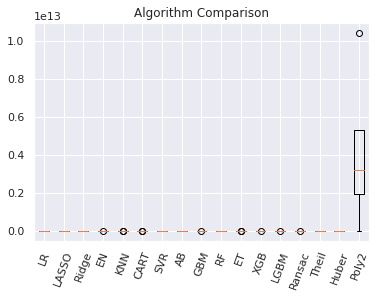

In [35]:
# Compare Algorithms
fig,ax = plt.subplots()
plt.title('Algorithm Comparison')
plt.boxplot(results)
ax.set_xticklabels(names,rotation=70)
plt.show()

#### Cross validate for multiple score evaluation

In [0]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time

num_folds=5
seed=42
scoring = {'r2': 'r2',
            'mse': "neg_mean_squared_error",
            'rmse': 'neg_root_mean_squared_error'}

time_=[]

names = []
cv_results_r2=[]
cv_results_mse=[]
cv_results_rmse=[]
cv_results_rmse_std=[]

for name, model in regressors.items():

  print(name)
  start = time.time()
  estimator = Pipeline(steps=[('preprocessor', preprocessor),
                        # ('dimred', PCA(n_components=8)),
                           ('regressors',model)])

  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
  cv_results = cross_validate(estimator, X_train, y_train, cv=kfold, scoring=scoring,
                               return_train_score=True)
  names.append(name)
  cv_results_r2.append(cv_results['test_r2'].mean())
  cv_results_mse.append(cv_results['test_mse'].mean())
  cv_results_rmse.append(cv_results['test_rmse'].mean())
  cv_results_rmse_std.append(cv_results['test_rmse'].std())

  
  time_cal=time.time() - start
  print('rmse: %0.2f time : %0.3f' % (cv_results['test_rmse'].mean(),time_cal))
  time_.append(time_cal)

LR


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -68283.34 time : 0.358
LASSO


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4998636982644.953, tolerance: 17733953972.591434
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4945525962792.125, tolerance: 17642232528.114216
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4946244287049.203, tolerance: 17676667512.48713
  po

rmse: -68283.23 time : 2.022
Ridge
rmse: -68285.00 time : 0.399
EN


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -78538.29 time : 0.391
KNN


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -61880.12 time : 9.608
CART


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -70593.44 time : 1.366
SVR


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -118781.47 time : 120.550
AB


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -82379.87 time : 7.621
GBM


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -52706.80 time : 23.083
RF


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -50174.81 time : 69.292
ET


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -50414.49 time : 26.177
XGB
[06:59:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[06:59:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: -52766.09 time : 5.941
LGBM


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse: -46172.86 time : 2.824


In [0]:
df_results_val=pd.DataFrame(list(zip(names,cv_results_rmse,cv_results_mse,cv_results_r2,time_)),
                  columns=['Names','CV_rmse','CV_mse','CV_r2','Time'])
df_results_val=df_results_val.sort_values(by='CV_rmse',ascending=False)
df_results_val

Names        CV_rmse        CV_mse     CV_r2        Time
12   LGBM  -46172.863748 -2.133809e+09  0.840921    2.824379
9      RF  -50174.810106 -2.519023e+09  0.812218   69.292156
10     ET  -50414.487053 -2.543388e+09  0.810430   26.176665
8     GBM  -52706.801538 -2.779261e+09  0.792811   23.082782
11    XGB  -52766.093595 -2.785980e+09  0.792294    5.941301
4     KNN  -61880.121307 -3.831693e+09  0.714498    9.607742
1   LASSO  -68283.234653 -4.663973e+09  0.652498    2.022287
0      LR  -68283.338637 -4.663987e+09  0.652497    0.358132
2   Ridge  -68284.996170 -4.664216e+09  0.652479    0.398905
5    CART  -70593.440866 -4.984137e+09  0.628487    1.366186
3      EN  -78538.289037 -6.169398e+09  0.540323    0.390930
7      AB  -82379.873530 -6.814674e+09  0.492304    7.620514
6     SVR -118781.472946 -1.411014e+10 -0.051339  120.550304

### Essemble learning

Create benmach:

In [0]:


lgbm_reg = LGBMRegressor(random_state=42)
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                          # ('dimred', PCA(n_components=8)),
                           ('regressors',lgbm_reg)])

estimator.fit(X_train, y_train)
y_pred=estimator.predict(X_test)

r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
mae_=mean_absolute_error(y_test, y_pred)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8303435237298786
rmse:  46759.31149165172
mae:  30803.471738177606


#### Average

In [0]:

models=[
      LGBMRegressor(random_state=123),
      RandomForestRegressor(),
      ExtraTreesRegressor()
]
y_pred=[]
for model in models:
  print(model)
  estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',model)])

  estimator.fit(X_train,y_train)
  y_pred.append(estimator.predict(X_test))

In [0]:
y_pred=(y_pred[0]+y_pred[1]+y_pred[2])/3

r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
mae_=mean_absolute_error(y_test, y_pred)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8222719180562592
rmse:  47858.70175220946
mae:  31221.74106095213


#### Weighted Averaging

In [0]:
y_pred=y_pred[0]*0.6+y_pred[1]*0.2+y_pred[2]*0.2

r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
mae_=mean_absolute_error(y_test, y_pred)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8285574738975623
rmse:  47004.795227772745
mae:  30740.004347137146


#### Bagging

In [0]:
# Base learner: LGBMRegressor


bl1=LGBMRegressor(random_state=123)
baggingLearner = BaggingRegressor(base_estimator=bl1, n_estimators=15, 
                                  max_samples=0.7, max_features=0.8)

# Fitting the model using the meta learner
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',baggingLearner)])
Bagging = estimator.fit(X_train, y_train)


In [0]:
y_pred=Bagging.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8224949795038681
rmse:  47828.65927696374
mae:  30740.004347137146


In [0]:
# Base learner: Suport vector machine

from sklearn.ensemble import BaggingRegressor
bl1=SVR()
baggingLearner = BaggingRegressor(base_estimator=bl1, n_estimators=15, 
                                  max_samples=0.7, max_features=0.8)

# Fitting the model using the meta learner
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',baggingLearner)])
Bagging = estimator.fit(X_train, y_train)

y_pred=Bagging.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  -0.049328967218910114
rmse:  116289.0218301821
mae:  30740.004347137146


#### Boosting

1. Adaboost

In [0]:
from sklearn.ensemble import AdaBoostRegressor

bl1=LGBMRegressor()
boosting = AdaBoostRegressor(base_estimator=bl1, n_estimators=300, 
                                  )

# Fitting the model using the meta learner
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',boosting)])
Boosting = estimator.fit(X_train, y_train)

y_pred=Boosting.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8096422147881861
rmse:  49529.986325633145
mae:  30740.004347137146


2. Stochastic Gradient Boosting

In [0]:
boosting = GradientBoostingRegressor(n_estimators=300, 
                                  )

# Fitting the model using the meta learner
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',boosting)])
Boosting = estimator.fit(X_train, y_train)

y_pred=Boosting.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8078016637697579
rmse:  49768.86062575869
mae:  30740.004347137146


#### Voting essemble

In [0]:


models=[
      ('LGBMRegressor',LGBMRegressor(random_state=123)),
      ('RandomForestRegressor',RandomForestRegressor()),
      ('ExtraTreesRegressor',ExtraTreesRegressor())
]
ensemble = VotingRegressor(models)

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',ensemble)])
voting = estimator.fit(X_train, y_train)

y_pred=voting.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8235370699628127
rmse:  47688.05717666628
mae:  30740.004347137146


#### Stacking

Method 1

In [0]:
estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', LassoCV()),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',stacking_regressor)])

Stacing = estimator.fit(X_train, y_train)

y_pred=Stacing.predict(X_test)
r2_=r2_score(y_test, y_pred)
mse_=mean_squared_error(y_test, y_pred)
rmse_= np.sqrt(mse_)
print('r2: ',r2_)
print('rmse: ',rmse_)
print('mae: ',mae_)

r2:  0.8293714837618646
rmse:  46893.072968805005
mae:  30740.004347137146


Method 2

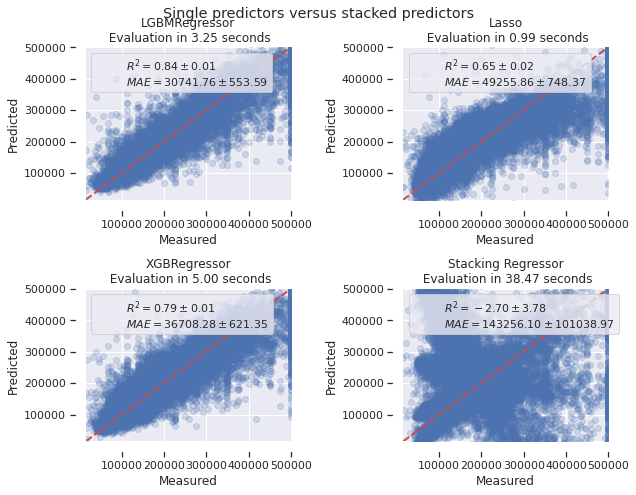

In [0]:
from sklearn.model_selection import cross_validate, cross_val_predict

lasso_pipeline = make_pipeline(preprocessor,
                               LassoCV())

rf_pipeline = make_pipeline(preprocessor,
                            LGBMRegressor(random_state=42))

gradient_pipeline = make_pipeline(preprocessor,
    XGBRegressor(random_state=0))

estimators = [('LGBMRegressor', rf_pipeline),
              ('Lasso', lasso_pipeline),
              ('XGBRegressor', gradient_pipeline)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
#--------------------------------------#

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X_train, y_train,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y_train, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Method 3

In [0]:
# get a stacking ensemble of models
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold

def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('LGBM', LGBMRegressor()))
	level0.append(('XGB', XGBRegressor()))
	level0.append(('Lasso', Lasso()))
	level0.append(('KNN', KNeighborsRegressor()))
	level0.append(('ET', ExtraTreesRegressor()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['LGBM'] = LGBMRegressor()
	models['XGB'] = XGBRegressor()
	models['Lasso'] = Lasso()
	models['KNN'] = KNeighborsRegressor()
	models['ET'] = ExtraTreesRegressor()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
#def evaluate_model(model):
  
  #estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            #('regressors',model)])
  #kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
  #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
	#scores = cross_val_score(estimator, X_train, y_train, 
                         # scoring='root_mean_squared_error',cv=cv,n_jobs=-1)
	#return scores

# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
	scores = cross_val_score(model, X_train, y_train, scoring='root_mean_squared_error',
                          cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  estimator = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressors',model)])
	scores = evaluate_model(estimator)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

TabError: ignored

### Visual all algorithm results

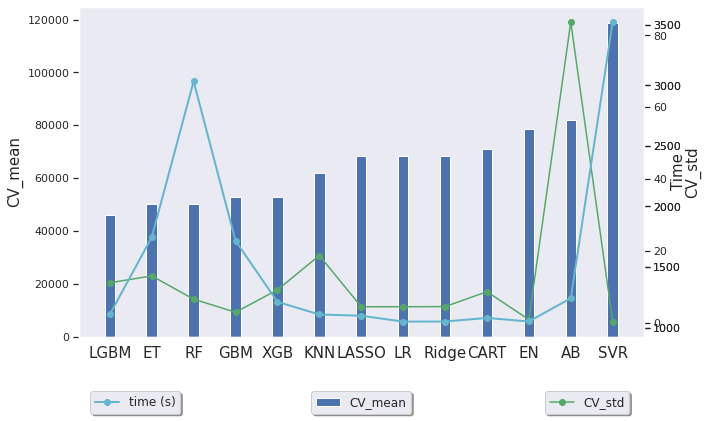

In [0]:
# Define name:
name=df_results['Names']
CV_mean=df_results['CV_mean']
CV_std=df_results['CV_std']
Time = df_results['Time']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, CV_mean, color = 'b', width = 0.25,label='CV_mean')

ax1 = ax.twinx()
ax1.plot(x, CV_std, color = 'g',marker='o',label='CV_std')
ax1.secondary_yaxis('right')

ax2 = ax.twinx()
ax2.plot(x,Time,color ='c',marker='o',lw=2,label='time (s)')
#ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15)
ax.set_ylabel('CV_mean',fontsize=15)
ax1.set_ylabel('CV_std',fontsize=15)
ax2.set_ylabel('Time',fontsize=15)

#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(0.5, -0.2),shadow=True, fontsize='medium')
legend2=ax1.legend(loc='center',bbox_to_anchor=(0.9, -0.2),shadow=True, fontsize='medium')
legend3=ax2.legend(loc='center',bbox_to_anchor=(0.1, -0.2),shadow=True, fontsize='medium')

ax.grid(False)
ax1.grid(False)
ax2.grid(False)
fig.tight_layout()
plt.show()

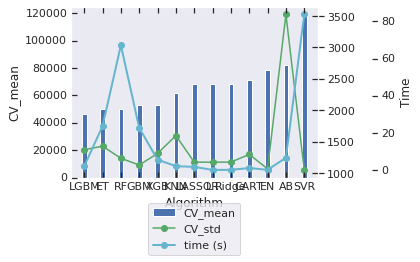

In [0]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Define name:
name=df_results['Names']
CV_mean=df_results['CV_mean']
CV_std=df_results['CV_std']
Time = df_results['Time']

#Axis
#fig, ax = plt.subplots(figsize=(10,6),axes_class=AA.Axes)
ax = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

ax1 = ax.twinx()
ax2 = ax.twinx()

offset = 60
new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
ax2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=ax2,
                                    offset=(offset, 0))
ax2.axis["right"].toggle(all=True)

# Plot:
x = np.arange(len(name))
ax.bar(x, CV_mean, color = 'b', width = 0.25,label='CV_mean')

ax1.plot(x, CV_std, color = 'g',marker='o',label='CV_std')
ax1.secondary_yaxis('right')

ax2.plot(x,Time,color ='c',marker='o',lw=2,label='time (s)')
#ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=90)

ax.set_xlabel("Algorithm")
ax.set_ylabel('CV_mean',fontsize=15)
ax1.set_ylabel('CV_std',fontsize=15)
ax2.set_ylabel('Time',fontsize=15)

#ax.legend()
plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.3))
#legend1=ax.legend(loc='center',bbox_to_anchor=(0.5, -0.2),shadow=True, fontsize='medium')
#legend2=ax1.legend(loc='center',bbox_to_anchor=(0.9, -0.2),shadow=True, fontsize='medium')
#legend3=ax2.legend(loc='center',bbox_to_anchor=(0.1, -0.2),shadow=True, fontsize='medium')

ax.grid(False)
ax1.grid(False)
ax2.grid(False)

plt.draw()
plt.tight_layout()
plt.show()

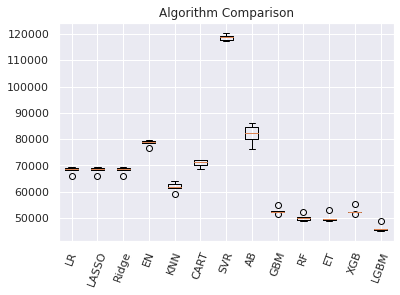

In [0]:
# Compare Algorithms
fig,ax = plt.subplots()
plt.title('Algorithm Comparison')
plt.boxplot(results)
ax.set_xticklabels(names,rotation=70)
plt.show()

### Check some model to cross check with Handson ML ebook

In [0]:
from sklearn.linear_model import LinearRegression

X_train_tran=preprocessor.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train_tran, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
lin_reg.coef_

array([-53707.4394972 , -53886.75844221,  13883.47479798,   6043.00517056,
         3904.10619569, -45522.21983681,  40663.18971066,  78163.50392295,
         7006.4118117 ,  15510.44256375,    779.36490586, -19521.08598151,
       -56188.70483443, 113642.00033495, -23631.65503111, -14300.5544879 ])

In [0]:
lin_reg.score(X_train_tran, y_train)

0.6552350872072379

In [0]:
lin_reg.intercept_

238049.2013888712

In [0]:
from sklearn.metrics import mean_squared_error

X_test_tran=preprocessor.fit_transform(X_test)
housing_predictions = lin_reg.predict(X_test_tran)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67397.2838309221

In [0]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, housing_predictions)
lin_mae

48898.46084464042

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_tran, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(X_train_tran)
tree_mse = mean_squared_error(y_train, housing_predictions)
print(tree_mse)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0
0.0


### Diagnosing bias and variance problems with learning curves

In [0]:
X_train.shape

(16512, 12)

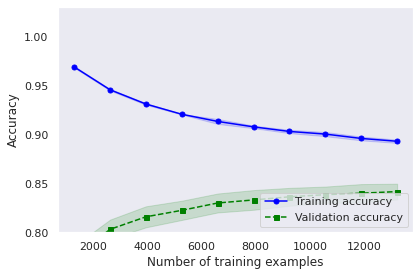

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

model = LGBMRegressor()

# Fitting the model using the meta learner
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                            # ('dimred', PCA(n_components=8)),
                            ('regressors',model)])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

Addressing over- and underfitting with validation curves

### Grid search CV

Base model

In [0]:
lgbm_reg = LGBMRegressor(random_state=42)
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                          # ('dimred', PCA(n_components=8)),
                           ('regressors',lgbm_reg)])

estimator.fit(X_train, y_train)
estimator.score(X_test,y_test)

0.8378305108985469

In [0]:
from sklearn.metrics import mean_squared_error
housing_predictions = estimator.predict(X_test)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46017.16351476771

In [0]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint 

lgbm_reg = LGBMRegressor(random_state=42)
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                        # ('dimred', PCA(n_components=8)),
                           ('regressors',lgbm_reg)])
learning_rate=[0.01,0.1] # small 0.1
num_leaves=[10,30] #large 31
boosting_type=['dart','gbdt'] #try dart
max_depth =[1,3]
#use bigger training data

param_grid = {
              'regressors__boosting_type': boosting_type,
              'regressors__learning_rate': learning_rate,
              'regressors__num_leaves': num_leaves,   
              'regressors__max_depth': max_depth,     
              }
pprint(param_grid)


# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(estimator, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           verbose=1,
                           #n_jobs = -1
)
grid_search.fit(X_train, y_train)
rmse=np.sqrt(-grid_search.best_score_)
print('rmse grid search',rmse)

{'regressors__boosting_type': ['dart', 'gbdt'],
 'regressors__learning_rate': [0.01, 0.1],
 'regressors__max_depth': [1, 3],
 'regressors__num_leaves': [10, 30]}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rmse grid search 52568.19428140659


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   22.7s finished


In [0]:
housing_predictions = grid_search.predict(X_test)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

52988.88261020348

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

140874.6336353389 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.01, 'regressors__max_depth': 1, 'regressors__num_leaves': 10}
140874.6336353389 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.01, 'regressors__max_depth': 1, 'regressors__num_leaves': 30}
134314.85153774117 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.01, 'regressors__max_depth': 3, 'regressors__num_leaves': 10}
134314.85153774117 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.01, 'regressors__max_depth': 3, 'regressors__num_leaves': 30}
77674.98106711979 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.1, 'regressors__max_depth': 1, 'regressors__num_leaves': 10}
77674.98106711979 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.1, 'regressors__max_depth': 1, 'regressors__num_leaves': 30}
63621.97687996114 {'regressors__boosting_type': 'dart', 'regressors__learning_rate': 0.1, 'regressors__max

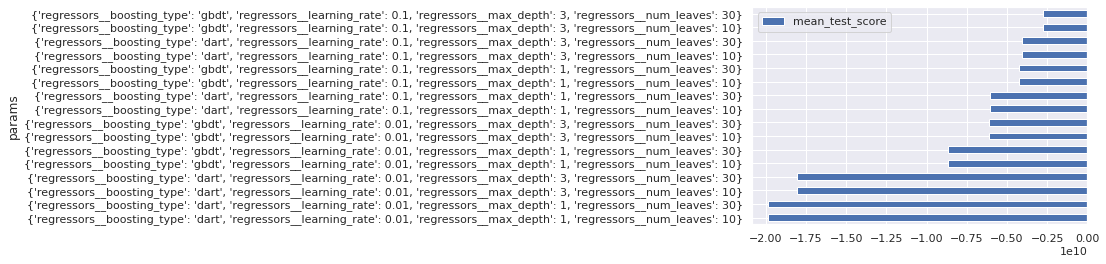

In [0]:
results = pd.DataFrame(grid_search.cv_results_)
results.loc[:,['params','mean_test_score']].sort_values('mean_test_score', ascending=True).plot.barh(x = 'params')

In [0]:
import joblib
joblib.dump(grid_search, "/content/drive/My Drive/Colab Notebooks/grid_model.pkl")

['/content/drive/My Drive/Colab Notebooks/grid_model.pkl']

Evaluate Result with confident level

In [0]:
housing_predictions = grid_search.predict(X_test)
rf_mse = mean_squared_error(y_test, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
print('rmse',rf_rmse)
#We can compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (housing_predictions - y_test) ** 2
confidence_range=np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
print('confidence_range \n ',confidence_range)

rmse 52988.88261020348
confidence_range 
  [50723.62270904 55161.19523566]


### Explanation

#### Feature Important

In [0]:
imp_vals=grid_search.best_estimator_.named_steps["regressors"].feature_importances_
imp_vals

array([147, 133,  58,  12,  17,   6,   3, 110,  36,  16,  78,   1,  34,
        11,  21,   0])

In [0]:
varimp_grid_df=pd.DataFrame({'feature': X_train_tran_df.columns, 'importance': imp_vals})
varimp_grid_df=varimp_grid_df.sort_values(by='importance',ascending=False)
varimp_grid_df

feature  importance
0                  longitude         147
1                   latitude         133
7              median_income         110
10  population_per_household          78
2         housing_median_age          58
8        rooms_per_household          36
12         ocean_proximity_2          34
14         ocean_proximity_4          21
4             total_bedrooms          17
9          bedrooms_per_room          16
3                total_rooms          12
13         ocean_proximity_3          11
5                 population           6
6                 households           3
11         ocean_proximity_1           1
15         ocean_proximity_5           0

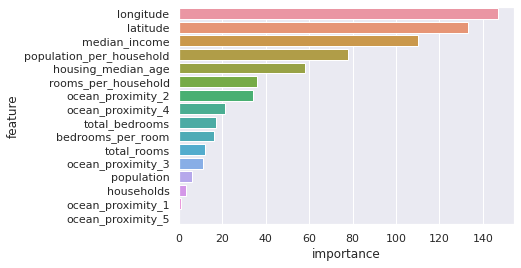

In [0]:
sns.barplot(x='importance',y='feature',data=varimp_grid_df)

In [0]:
dt_column_tran=pd.concat([X_train_tran_df,y_train],axis=1)
dt_column_tran.corr().sort_values(by='median_house_value',ascending=False)['median_house_value']

median_house_value          1.000000
ocean_proximity_3           0.013964
median_income               0.006713
bedrooms_per_room           0.006652
ocean_proximity_5           0.004680
ocean_proximity_4           0.004573
housing_median_age          0.004213
households                  0.003026
ocean_proximity_2           0.001954
longitude                   0.001717
total_bedrooms              0.000306
total_rooms                -0.001120
latitude                   -0.001345
population_per_household   -0.003566
population                 -0.003707
rooms_per_household        -0.004542
ocean_proximity_1          -0.014285
Name: median_house_value, dtype: float64

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 7.9MB/s 


In [0]:
import eli5
model=grid_search.best_estimator_
eli5.explain_weights(model.named_steps['regressors'], top=50, feature_names=list(X_train_tran_df.columns))

Explanation(estimator="LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n              importance_type='split', learning_rate=0.1, max_depth=3,\n              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,\n              n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,\n              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='median_income', weight=0.5648940617990177, std=None, value=None), FeatureWeight(feature='ocean_proximity_2', weight=0.15536044532076845, std=None, value=None), FeatureWeight(feature='population_per_household', weight=0.10791206655410986, std=None, value=None), FeatureWeight(feature='longitude', weight=0.06702737042959588, std=None, value=None), FeatureWeight(feature='latitude', weight=0.04505344929902261, std=None, value=None), FeatureWeight(feature='housing_median_age', weight=0.032812835594759324, std=None, value=None), FeatureWeight(feature='rooms_per_household', weight=0.008532499399290116, std=None, value=None), FeatureWeight(feature='ocean_proximity_4', weight=0.006320614360520195, std=None, value=None), FeatureWeight(feature='bedrooms_per_room', weight=0.00395075833515369, std=None, value=None), FeatureWeight(feature='total_rooms', weight=0.003047257142274475, std=None, value=None), FeatureWeight(feature='ocean_proximity_3', weight=0.0027210502318479406, std=None, value=None), FeatureWeight(feature='total_bedrooms', weight=0.0017734586413881018, std=None, value=None), FeatureWeight(feature='population', weight=0.00035861499585961476, std=None, value=None), FeatureWeight(feature='households', weight=0.00017663197540701865, std=None, value=None), FeatureWeight(feature='ocean_proximity_1', weight=5.8885920985087554e-05, std=None, value=None), FeatureWeight(feature='ocean_proximity_5', weight=0.0, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

#### Plot partial dependence

/usr/local/lib/python3.6/dist-packages/sklearn/inspection/_partial_dependence.py:950: UserWarning: Attempting to set identical bottom == top == 206292.1153655423 results in singular transformations; automatically expanding.
  axi.set_ylim(self.pdp_lim[1])


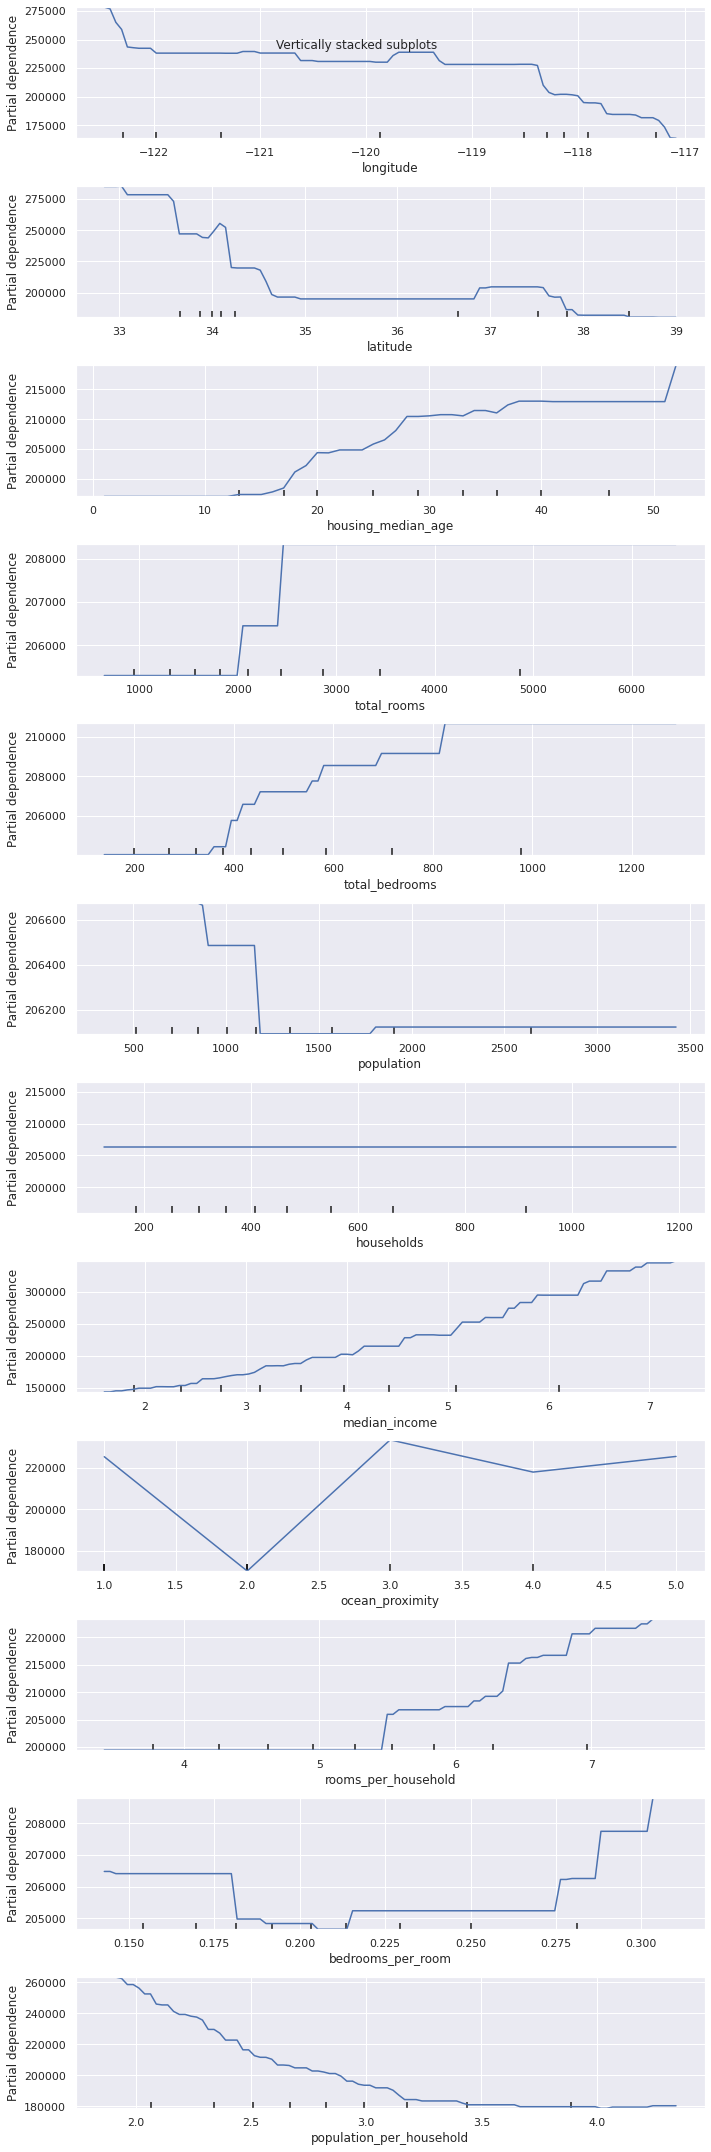

In [0]:
from sklearn.inspection import plot_partial_dependence


n=len(X_test.columns)
i=0
fig, ax = plt.subplots(n,figsize=(10,30))
fig.suptitle('Vertically stacked subplots')

for name in X_test.columns:
  features= [X_test.columns.get_loc(name)]
  plot_partial_dependence(grid_search,X_test, features=features,ax=ax[i])
  i+=1

plt.tight_layout()
#plt.savefig('image.png')
plt.show()

In [0]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 73kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=d8c7f2ee457ecae9f536d28d9f11a0b4af42cd181bcd35c6fc7e3dfc0e8592da
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


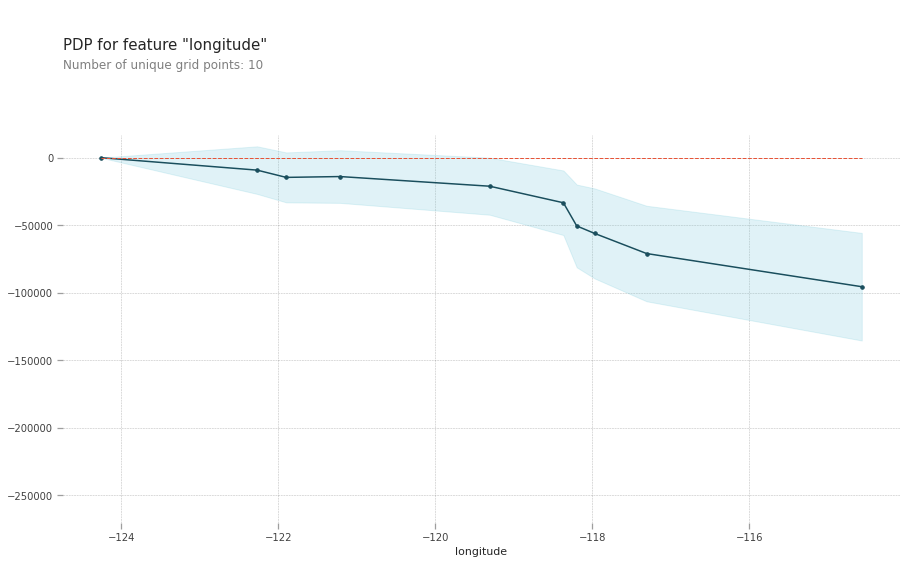

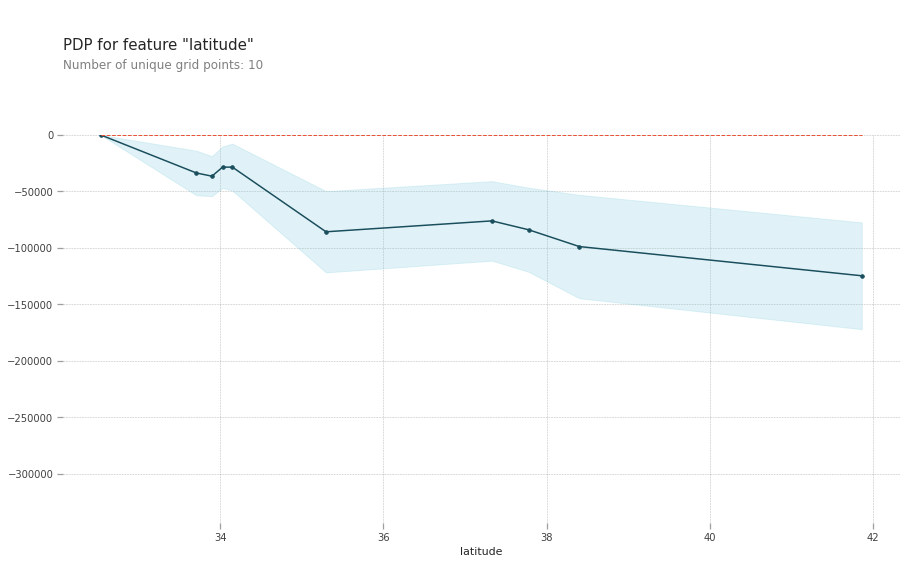

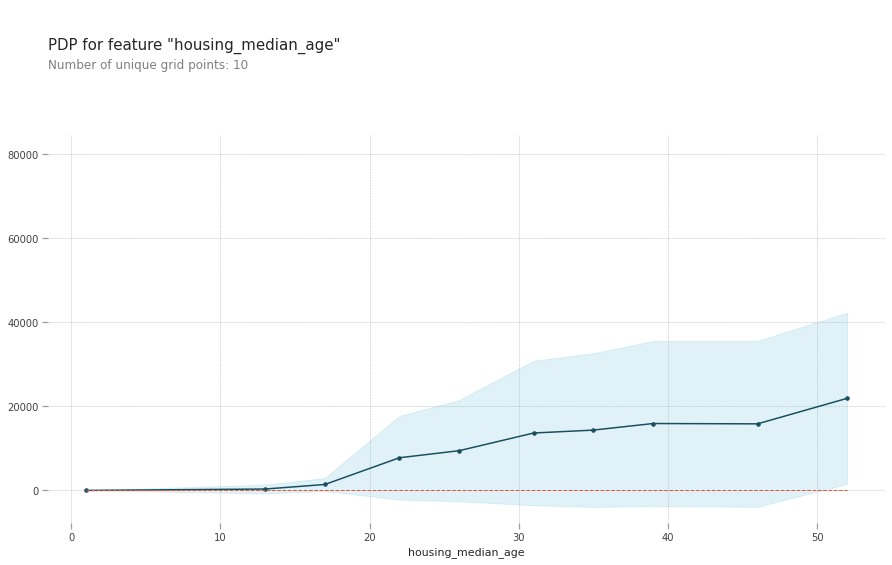

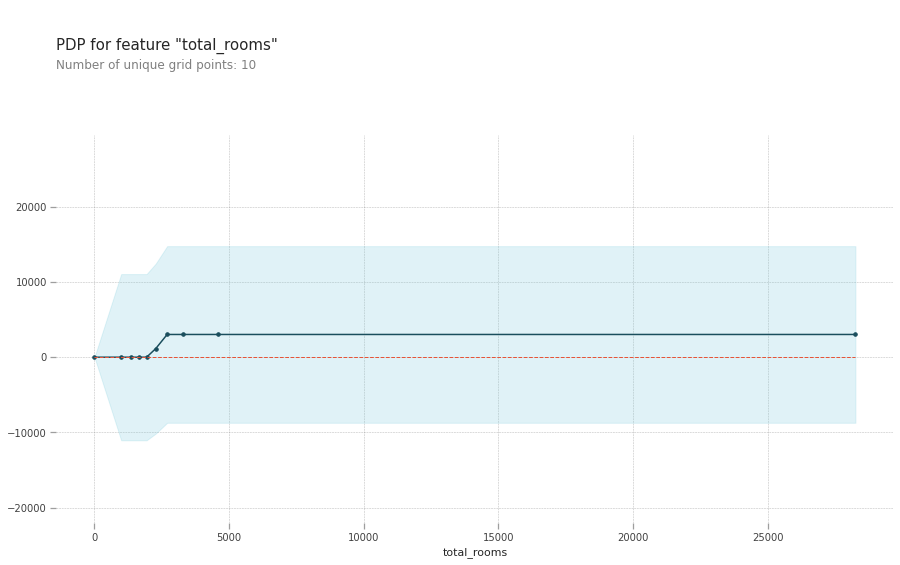

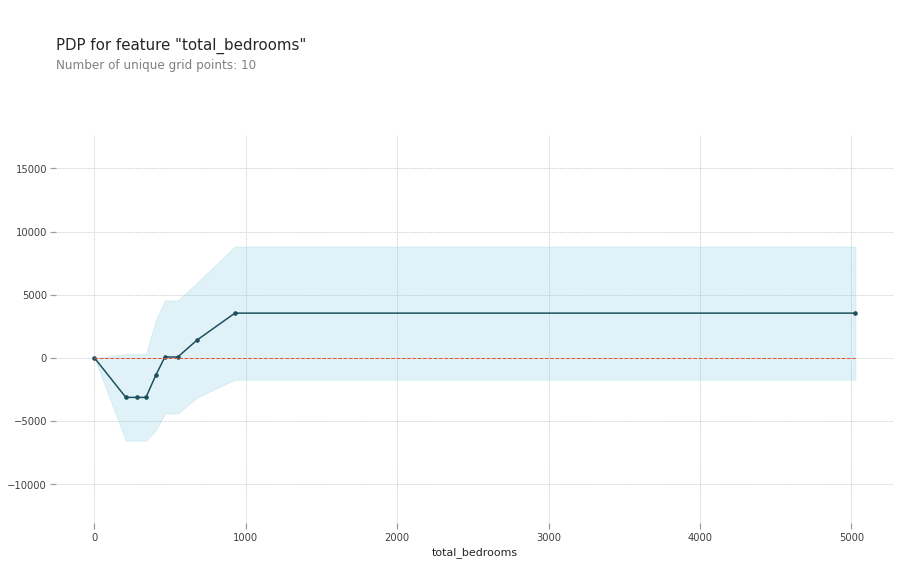

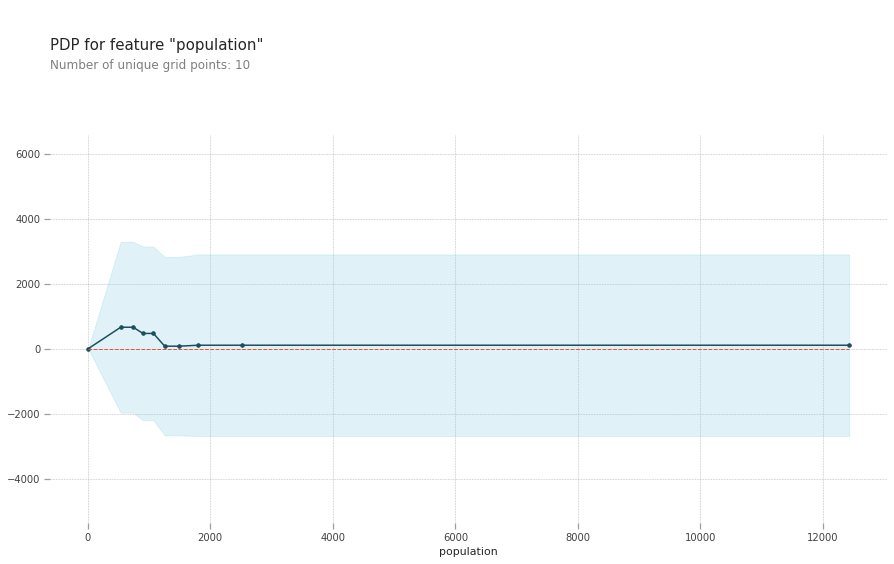

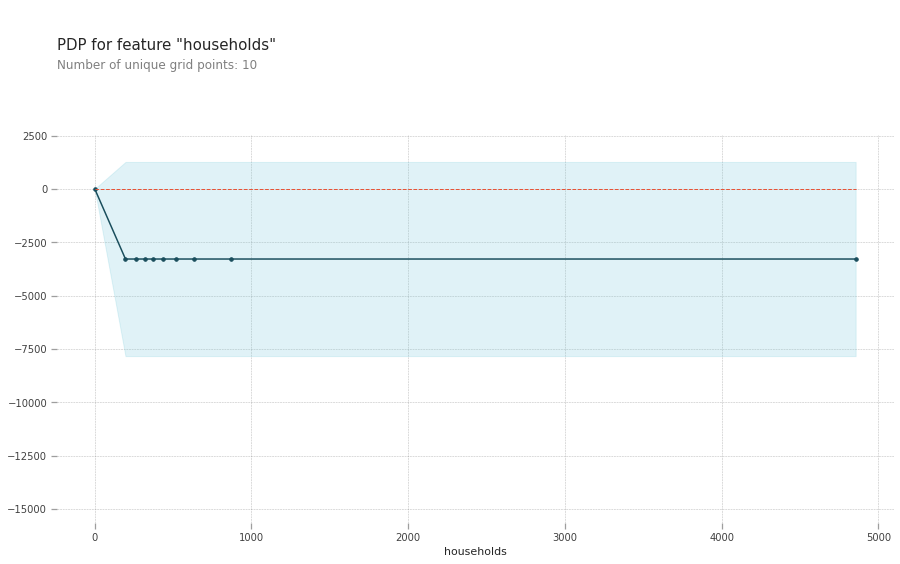

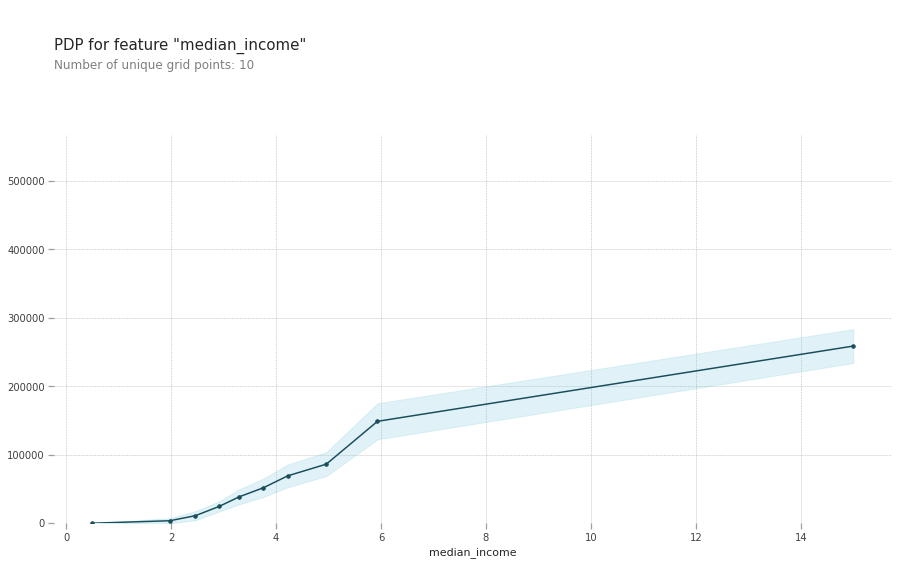

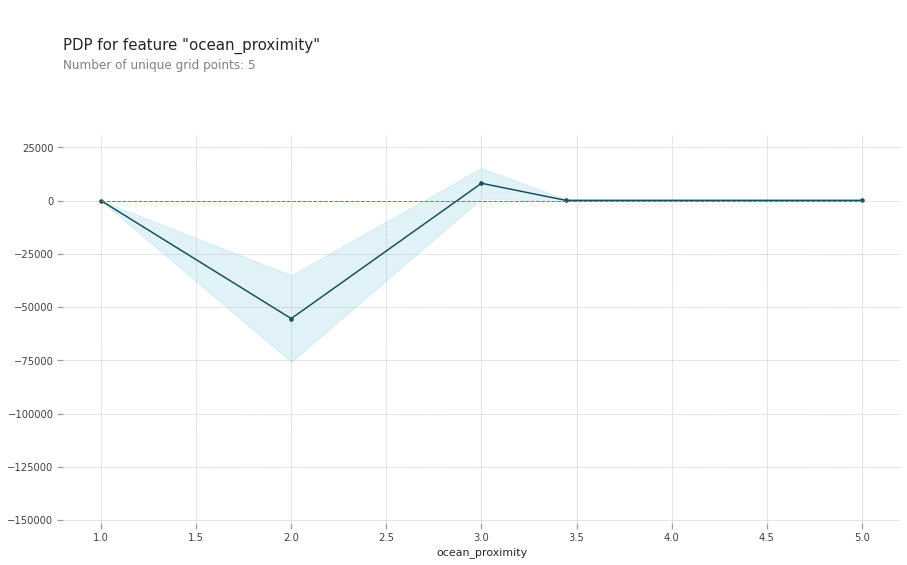

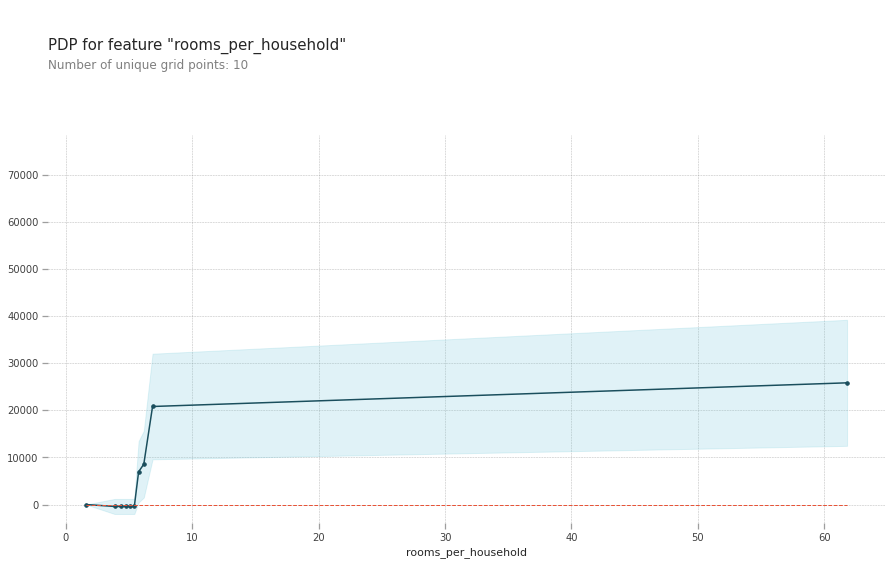

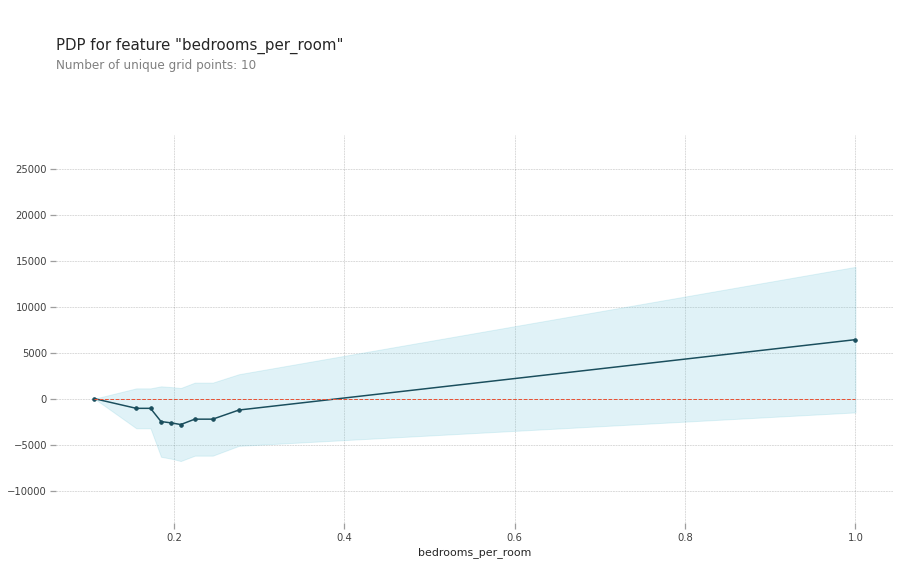

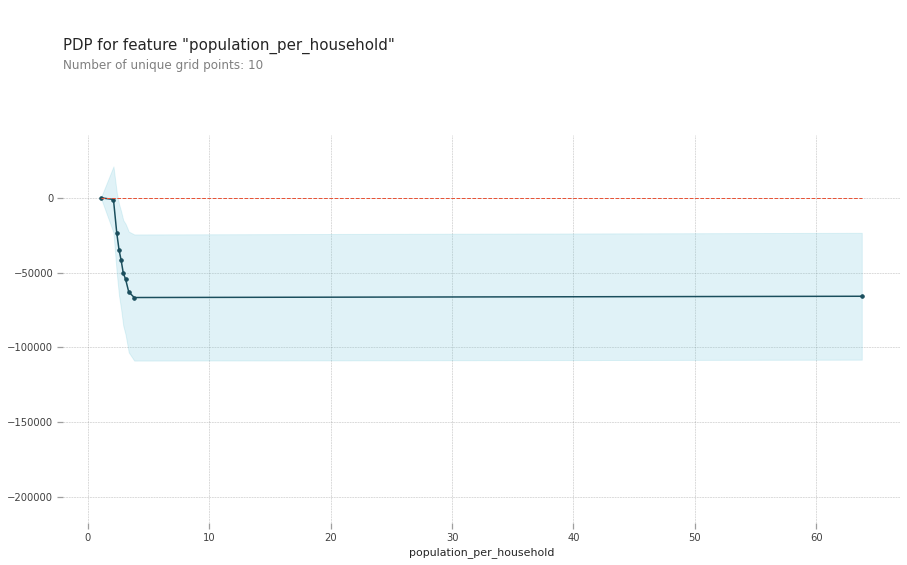

In [0]:
from pdpbox import pdp, info_plots #for partial plots

n=len(X_test.columns)
i=0
#fig, ax = plt.subplots(n,figsize=(10,30))
#fig.suptitle('Vertically stacked subplots')
base_features = X_train.columns.values.tolist()

for name in X_test.columns:
  feat_name = name
  pdp_dist = pdp.pdp_isolate(model=grid_search, dataset=X_test, model_features=base_features, feature=feat_name)
  pdp.pdp_plot(pdp_dist, feat_name)
  #i+=1

plt.tight_layout()
plt.savefig('image2.png')
plt.show()


#### SHAPE

In [0]:
!pip install shap
import shap

  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394108 sha256=7f47f20977b6add4172575a3380496880a2aefb8f12b1eda5bed0dc2d00bcede
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
X_test_tran_df.head()

longitude  latitude  ...  ocean_proximity_4  ocean_proximity_5
0  -0.446157  0.581448  ...                0.0                0.0
1  -1.084679  0.403485  ...                0.0                0.0
2  -1.568558  1.316717  ...                0.0                0.0
3   0.396891 -0.636193  ...                0.0                0.0
4   0.711163 -0.725175  ...                0.0                0.0

[5 rows x 16 columns]

In [0]:
model = grid_search.best_estimator_.named_steps['regressors']
#model = RandomForestClassifier(max_depth=5)
#model.fit(X_train_tran_df, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_tran_df)
shap_values

array([[ 16580.40902248, -29042.70012602,   2390.43221311, ...,
          -900.44116782,    963.91027228,      0.        ],
       [ -7899.58547638,  16391.73788755,   1408.19983047, ...,
          -776.10526087,    705.45319157,      0.        ],
       [-47170.69950065,  14570.57763987, -26890.51454202, ...,
          2426.13609969,    705.45319157,      0.        ],
       ...,
       [ -3034.17858472,   3636.27256061,   2764.36435835, ...,
          -772.93396946,    749.06185804,      0.        ],
       [ 30339.70712574, -31800.22982578,  -6589.49029294, ...,
         -1146.87591448, -12849.54199152,      0.        ],
       [ 20767.42463873,  18030.63668019,  12060.59508594, ...,
         -1341.53586526,    611.96472203,      0.        ]])

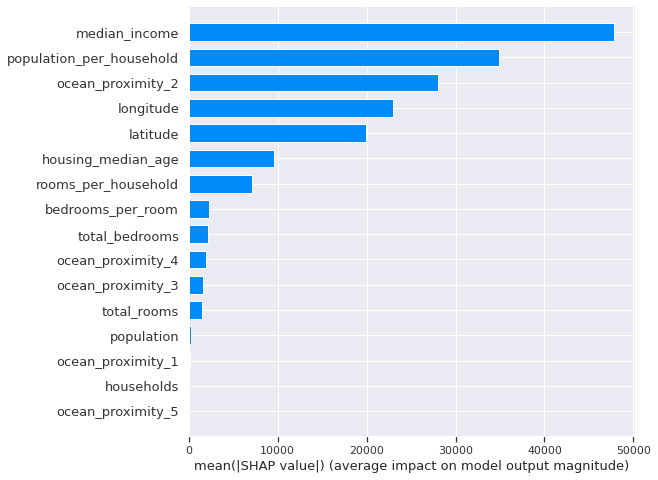

In [0]:
shap.summary_plot(shap_values, X_test_tran_df, plot_type="bar")

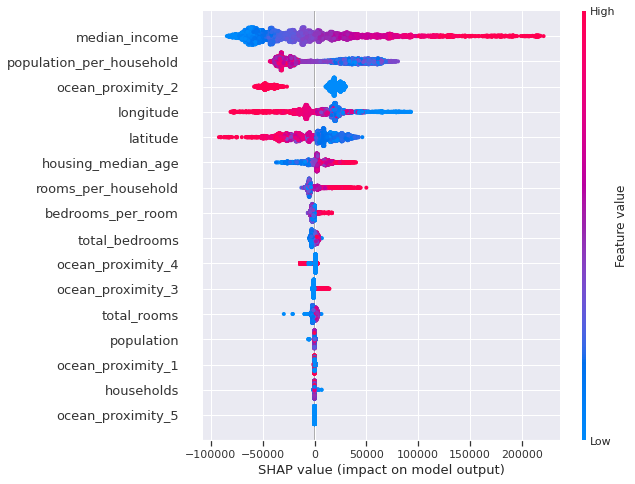

In [0]:
shap.summary_plot(shap_values, X_test_tran_df)

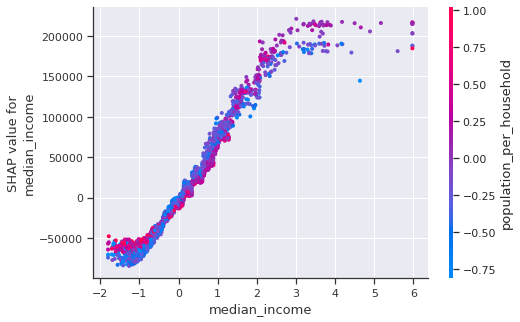

In [0]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('median_income', shap_values, 
                     X_test_tran_df, interaction_index="population_per_household")

In [0]:
y_train.describe()

count     16512.000000
mean     207069.699491
std      115674.138815
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      265000.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [0]:
y_train

2503      63000.0
9761     274600.0
19205    350000.0
20455    196400.0
6795     170000.0
           ...   
9509     154600.0
13045    273200.0
3711     211900.0
5648     306700.0
439      120000.0
Name: median_house_value, Length: 16512, dtype: float64

In [0]:
data_for_prediction = X_train_tran_df.astype(float)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],data_for_prediction.iloc[0,:])

In [0]:
data_for_prediction = X_train_tran_df.astype(float)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:],data_for_prediction.iloc[3,:])

In [0]:
#f = plt.figure()
shap_values = explainer.shap_values(X_train_tran_df.iloc[:50])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, 
                X_train_tran_df.iloc[:50],show=False)
#f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

In [0]:
y_train[:10]

2503      63000.0
9761     274600.0
19205    350000.0
20455    196400.0
6795     170000.0
18391    305600.0
20031     78000.0
5668     267800.0
3324     105700.0
17929    287100.0
Name: median_house_value, dtype: float64

In [0]:
X_train_tran_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_1', 'ocean_proximity_2', 'ocean_proximity_3',
       'ocean_proximity_4', 'ocean_proximity_5'],
      dtype='object')

### Deep learning

In [0]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import random

# Load Keras and sklearn
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

from keras import models
from keras import layers
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

#Load visual neural:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


Benchmark rmse: 46000

In [0]:
# for reference
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                        # ('dimred', PCA(n_components=8)),
                           ('regressors',model)])

DL 1 Base no tunning

In [0]:
def plot_loss_accuracy(model):
  # plot training error and test error
  fig,ax=plt.subplots()
  ax.plot(model.history['loss'],label='train loss')
  ax.plot(model.history['val_loss'],label='validation loss')

  ax.set(xlabel='epoch', ylabel='loss')
  ax.legend()

  #plt.legend(['train loss', 'validation loss','train_accuracy','val_accuracy'], loc='lower right')

  # print the best accuracy reached on the test set
  print("Best Loss on Validation Set =", min(model.history['val_loss']))
  print("Best Loss on Train Set =", min(model.history['loss']))

In [0]:
# define a seed for random number generator so the result will be reproducible
seed=7
np.random.seed(seed)
random.set_seed(seed)
# create model
model_1 = Sequential()
model_1.add(Dense(10, input_dim=X_test_tran_df.shape[1], activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(1))
# Compile model
#model_1.summary()

In [0]:
# train the model using training set while evaluationg on test set
model_1.compile(loss='mean_squared_error', optimizer='adam')

history=model_1.fit(X_train_tran_df, y_train, batch_size = 50, epochs = 200, 
                    validation_data=(X_test_tran_df, y_test), verbose=0)

#evaluate
mse_val= min(history.history['val_loss'])
mse_train= min(history.history['loss'])
rmse_val=np.sqrt(mse_val)
rmse_train=np.sqrt(mse_train)

print('rmse_val: ',rmse_val)
print('rmse_train: ',rmse_train)

rmse_val:  73485.86712364989
rmse_train:  65225.313435028234


Best Loss on Validation Set = 5400172666.914729
Best Loss on Train Set = 4254341512.6976743


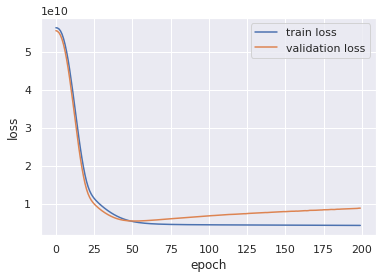

In [0]:
plot_loss_accuracy(history)

DL 2 drop out + stop early

In [0]:
# define a seed for random number generator so the result will be reproducible
np.random.seed(seed)
random.set_seed(seed)

# create model
model_1 = Sequential()
model_1.add(Dense(10, input_dim=X_train_tran_df.shape[1], activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(1))
# Compile model
model_1.compile(loss='mean_squared_error', optimizer='adam')

# define the early stopping callback
es_callback = EarlyStopping(monitor='val_loss', mode='min')
# train the model using training set while evaluationg on test set
history=model_1.fit(X_train_tran_df, y_train, batch_size = 50, epochs = 200, 
                    validation_data=(X_test_tran_df, y_test), callbacks=[es_callback],
                    verbose=0, shuffle=False)
#evaluate
mse_val= min(history.history['val_loss'])
mse_train= min(history.history['loss'])
rmse_val=np.sqrt(mse_val)
rmse_train=np.sqrt(mse_train)

print('rmse_val: ',rmse_val)
print('rmse_train: ',rmse_train)

rmse_val:  73133.3689210092
rmse_train:  85224.27584080223


Best Loss on Validation Set = 5348489649.736434
Best Loss on Train Set = 7263177192.589148


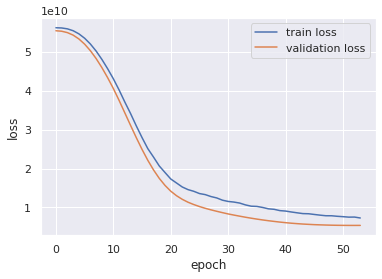

In [0]:
plot_loss_accuracy(history)

DL 3 : L1 and L2 , drop out, add more neuron

In [0]:
np.random.seed(seed)
random.set_seed(seed)

# create model
l1_param = 0.005
l2_param = 0.005

model = Sequential()
model.add(Dense(100, input_dim=X_train_tran_df.shape[1], activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param)))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param)))
#model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(30, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param)))
#model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param)))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# define the early stopping callback
es_callback = EarlyStopping(monitor='val_loss', mode='min')
# train the model using training set while evaluationg on test set
history=model.fit(X_train_tran_df, y_train, batch_size = 50, epochs = 200, 
                    validation_data=(X_test_tran_df, y_test), callbacks=[es_callback],
                    verbose=0, shuffle=False)
#evaluate
mse_val= min(history.history['val_loss'])
mse_train= min(history.history['loss'])
rmse_val=np.sqrt(mse_val)
rmse_train=np.sqrt(mse_train)

print('rmse_val: ',rmse_val)
print('rmse_train: ',rmse_train)

rmse_val:  72051.56093505744
rmse_train:  93568.34783708239


Best Loss on Validation Set = 5191427433.178294
Best Loss on Train Set = 8755035716.96124


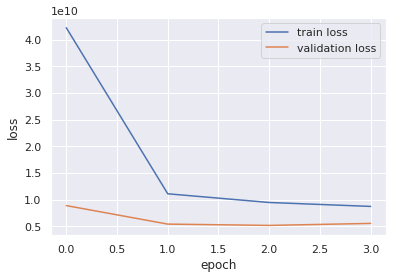

In [0]:
plot_loss_accuracy(history)

### Random Search CV

In [0]:
from pprint import pprint
LGBM_reg = LGBMRegressor(random_state=42)
print('Parameters currently in use:\n')
pprint(LGBM_reg.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

max_features = ['auto', 'sqrt']
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': max_features,
        #'max_depth': max_depth,
        #'min_samples_split': min_samples_split,
        #'min_samples_leaf': min_samples_leaf,
        #'bootstrap': bootstrap}
    }
pprint(param_distribs)


{'max_features': ['auto', 'sqrt'],
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1e2427fb70>}


In [0]:
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                verbose=2,n_jobs = -1,random_state=42)
rnd_search.fit(X_train_tran, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

AttributeError: ignored

In [0]:
rnd_search.best_params_

In [0]:
rand_model=rnd_search.best_estimator_
rand_model

In [0]:
results = pd.DataFrame(rnd_search.cv_results_)
results.loc[:,['params','mean_test_score']].sort_values('mean_test_score', ascending=True).plot.barh(x = 'params')

#### Feature important

In [0]:
varimp_rand_df=pd.DataFrame()
varimp_rand_df['feature']=X_train_tran_df.columns
varimp_rand_df['importance']=rand_model.feature_importances_
varimp_rand_df=varimp_rand_df.sort_values(by='importance',ascending=False)
varimp_rand_df

feature  importance
7                median_income    0.291033
12      ocean_proximity_INLAND    0.134958
10    population_per_household    0.099140
9            bedrooms_per_room    0.094530
0                    longitude    0.081424
1                     latitude    0.074914
8          rooms_per_household    0.063417
2           housing_median_age    0.042766
3                  total_rooms    0.023102
5                   population    0.022772
4               total_bedrooms    0.020302
6                   households    0.020126
11   ocean_proximity_<1H OCEAN    0.017880
15  ocean_proximity_NEAR OCEAN    0.007852
14    ocean_proximity_NEAR BAY    0.005641
13      ocean_proximity_ISLAND    0.000143

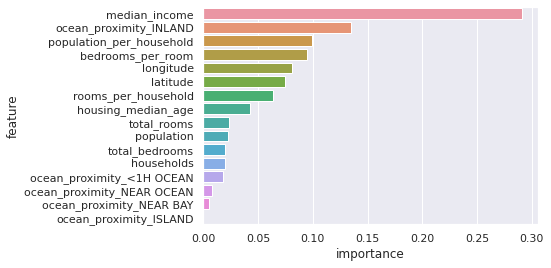

In [0]:
sns.barplot(x='importance',y='feature',data=varimp_df)

#### Evaluate result

In [0]:
housing_predictions = rand_model.predict(X_test_tran)
rf_mse = mean_squared_error(y_test, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

#We can compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (housing_predictions - y_test) ** 2
confidence_range=np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
print(confidence_range)

NameError: ignored

In [0]:
# We could compute the interval manually like this:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(47348.47943408696, 51790.79466283939)

In [0]:
# Alternatively, we could use a z-scores rather than t-scores:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(47349.16140454233, 51790.17117962779)

In [0]:
X_train_tran_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

done in 141.461s


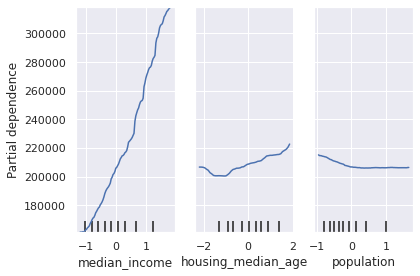

In [0]:
from sklearn.inspection import plot_partial_dependence
from time import time

tic = time()
features=['median_income','housing_median_age','population']
plot_partial_dependence(rand_model,X_train_tran_df, features=features) 
plt.tight_layout()
print("done in {:.3f}s".format(time() - tic))

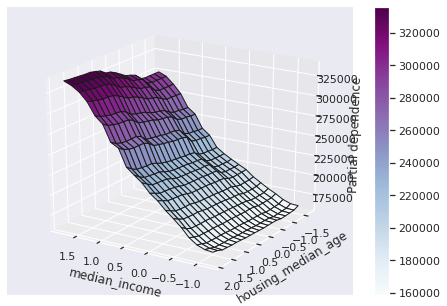

In [0]:
from sklearn.inspection import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ('median_income', 'housing_median_age')
pdp, axes = partial_dependence(rand_model, X_train_tran_df, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
#plt.suptitle('Partial dependence of house value on median age and average occupancy, with Randomforest')
plt.subplots_adjust(top=0.9)

plt.show()

In [0]:
!pip install lime

In [0]:
from lime.lime_tabular import LimeTabularExplainer

In [0]:
lime_explainer = LimeTabularExplainer(X_train_tran_df.values,
      feature_names=X_train_tran_df.columns, mode='regression')

In [0]:
exp = lime_explainer.explain_instance(X_test_tran_df.values[1], rand_model.predict)
exp.show_in_notebook()

#### Model persistence using joblib

In [0]:
import joblib
joblib.dump(rand_model, "/content/drive/My Drive/Colab Notebooks/Jason brownlee/rand_model.pkl")

['/content/drive/My Drive/Colab Notebooks/Jason brownlee/rand_model.pkl']

In [0]:
my_model_loaded = joblib.load("/content/drive/My Drive/Colab Notebooks/Jason brownlee/rand_model.pkl") # DIFF

In [0]:
housing_predictions = my_model_loaded.predict(X_test_tran)
rf_mse = mean_squared_error(y_test, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)


49619.375835093706


### Grid search SVM

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 
         'C': [10., 30.]},
        {'kernel': ['rbf'], 
         'C': [1.0, 3.0],
         'gamma': [0.01, 0.03]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_tran, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   9.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.6s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0], 'kernel': ['linear']},
                         {'C': [1.0, 3.0], 'gamma': [0.01, 0.03],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

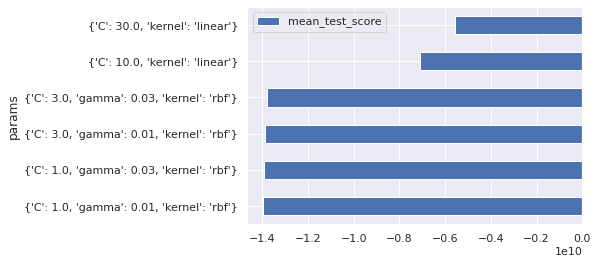

In [0]:
results = pd.DataFrame(grid_search.cv_results_)
results.loc[:,['params','mean_test_score']].sort_values('mean_test_score', ascending=True).plot.barh(x = 'params')

In [0]:
grid_search.best_params_

{'C': 30.0, 'kernel': 'linear'}

In [0]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

74774.70275273397

In [0]:
grid_svm_model=grid_search.best_estimator_
grid_svm_model

SVR(C=30.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
joblib.dump(grid_svm_model, "/content/drive/My Drive/Colab Notebooks/Jason brownlee/grid_model.pkl")

['/content/drive/My Drive/Colab Notebooks/Jason brownlee/grid_model.pkl']

Evaluate result

In [0]:
housing_predictions = grid_svm_model.predict(X_test_tran)
rf_mse = mean_squared_error(y_test, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)
#We can compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (housing_predictions - y_test) ** 2
confidence_range=np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
print(confidence_range)

74566.48473776002
[71753.35164956 77277.27880397]


#### Feature important (general , apply all)

In [0]:
from mlxtend.evaluate import feature_importance_permutation
imp_vals, _ = feature_importance_permutation(predict_method=grid_svm_model.predict, X=X_test_tran, y=y_test, metric='r2', num_rounds=1, seed=2)
imp_vals

array([6.61804014e-02, 4.68294504e-02, 1.96253041e-02, 3.02450651e-03,
       8.33121946e-03, 4.92542279e-02, 1.73066875e-02, 7.54650045e-01,
       5.35501277e-04, 9.37943961e-03, 6.24663635e-04, 8.25919751e-03,
       5.72755608e-02, 1.48404863e-06, 2.72346025e-03, 5.77011689e-03])

In [0]:
varimp_grid_df=pd.DataFrame({'feature': X_train_tran_df.columns, 'importance': imp_vals})
varimp_grid_df=varimp_grid_df.sort_values(by='importance',ascending=False)
varimp_grid_df

feature  importance
7                median_income    0.754650
0                    longitude    0.066180
12      ocean_proximity_INLAND    0.057276
5                   population    0.049254
1                     latitude    0.046829
2           housing_median_age    0.019625
6                   households    0.017307
9            bedrooms_per_room    0.009379
4               total_bedrooms    0.008331
11   ocean_proximity_<1H OCEAN    0.008259
15  ocean_proximity_NEAR OCEAN    0.005770
3                  total_rooms    0.003025
14    ocean_proximity_NEAR BAY    0.002723
10    population_per_household    0.000625
8          rooms_per_household    0.000536
13      ocean_proximity_ISLAND    0.000001

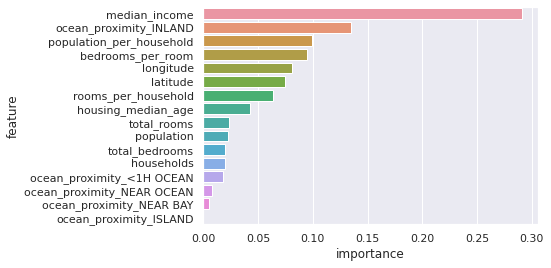

In [0]:
sns.barplot(x='importance',y='feature',data=varimp_df)

### Regression Model Study

In [0]:
X_train_tran_df.head()

longitude  latitude  ...  ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN
0  -0.873805  1.422429  ...                       0.0                         0.0
1   0.300232  0.940098  ...                       0.0                         0.0
2  -1.093624  0.968195  ...                       0.0                         0.0
3  -0.848825  1.075900  ...                       0.0                         0.0
4   0.854776 -0.890890  ...                       0.0                         0.0

[5 rows x 16 columns]

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.correlation import plot_corr

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures


Polynomial regression

In [0]:
#Polynomial regression
degree=2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_tran_df)
X_test_poly = poly_features.fit_transform(X_test_tran_df)
print(X_train_tran_df.shape)
print(X_train_poly.shape)

(16512, 16)
(16512, 152)


In [0]:
def regression_result(name,model):

  model.fit(X_train_poly, y_train)
  y_train_pred = model.predict(X_train_poly)
  y_test_pred = model.predict(X_test_poly)

  mse_train=mean_squared_error(y_train, y_train_pred)
  rmse_train=np.sqrt(mse_train)

  mse_test=mean_squared_error(y_test, y_test_pred)
  rmse_test=np.sqrt(mse_test)
  #print(lasso.coef_)
  print('---------------------')
  print(name)
  print('RMSE train: %.3f, test: %.3f' % (rmse_train,rmse_test))
  print('R^2 train: %.3f, test: %.3f' % (
          r2_score(y_train, y_train_pred),
          r2_score(y_test, y_test_pred)))

In [0]:
lin_reg = LinearRegression()
lasso = Lasso(alpha=0.1,random_state=42)
ridge_reg = Ridge(alpha=1, random_state=42) #solver="cholesky",'sag'
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5,random_state=42)
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)

Linear_model={'Linear_reg':lin_reg,'Lasso_reg':lasso,
              'Ridge_reg':ridge_reg,'Elanet_reg':elanet,
              'Sgd_reg':sgd_reg}

In [0]:
# Feed poly feature to these model
for name,model in Linear_model.items():
  regression_result(name,model)


---------------------
Linear_reg
RMSE train: 59464.028, test: 56535542924.351
R^2 train: 0.733, test: -236407527094.072


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29328981925586.3, tolerance: 21902001458.406868
  positive)


---------------------
Lasso_reg
RMSE train: 59599.809, test: 66972.636
R^2 train: 0.732, test: 0.668
---------------------
Ridge_reg
RMSE train: 59519.441, test: 223904.491
R^2 train: 0.733, test: -2.708
---------------------
Elanet_reg
RMSE train: 73113.885, test: 74748.760
R^2 train: 0.597, test: 0.587
---------------------
Sgd_reg
RMSE train: 236463650131614.844, test: 118354879374554.375
R^2 train: -4215456914753634304.000, test: -1036073343390766720.000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23819259408.296875, tolerance: 21902001458.406868
  positive)


In [0]:
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.api as sm
import patsy

In [0]:
X_train_tran_df

longitude  ...  ocean_proximity_NEAR OCEAN
0      -0.873805  ...                         0.0
1       0.300232  ...                         0.0
2      -1.093624  ...                         0.0
3      -0.848825  ...                         0.0
4       0.854776  ...                         0.0
...          ...  ...                         ...
16507  -1.193542  ...                         0.0
16508  -1.213526  ...                         0.0
16509   1.289420  ...                         0.0
16510  -1.313444  ...                         0.0
16511   0.674924  ...                         0.0

[16512 rows x 16 columns]

In [0]:
# Convert y_train and y_test to dataframe
y_train_df=pd.DataFrame(y_train).reset_index(drop=True)
y_test_df=pd.DataFrame(y_test).reset_index(drop=True)
y_train_df.head()

median_house_value
0            130600.0
1            162500.0
2            256700.0
3             61200.0
4            150500.0

In [0]:
train_data = pd.concat([X_train_tran_df, y_train_df], axis = 1)
test_data = pd.concat([X_test_tran_df, y_test_df], axis = 1)

In [0]:
#Method 1: combine X train and y train to one model:
linearModelResult = smf.ols(formula='median_house_value ~ median_income +rooms_per_household',data=train_data).fit()
linearModelResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     7544.
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        13:32:54   Log-Likelihood:            -2.1050e+05
No. Observations:               16512   AIC:                         4.210e+05
Df Residuals:                   16509   BIC:                         4.210e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.068e+05    647.910    319.120      0.000    2.05e+05    2.08e+05
median_income         8.21e+04    685.955    119.688      0.000    8.08e+04    8.34e+04
rooms_per_household -9059.3923    685.955    -13.207      0.000   -1.04e+04   -7714.847
==============================================================================
Omnibus:                     3879.722   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10781.521
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       6.077   Cond. No.                         1.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
# Method 2: use data frame y train and x train:
olsres  = sm.OLS(y_train_df,X_train_tran_df).fit()
olsres .summary()
#results.params
#results.rsquared
#results.pvalues

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2085.
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        14:18:40   Log-Likelihood:            -2.0708e+05
No. Observations:               16512   AIC:                         4.142e+05
Df Residuals:                   16496   BIC:                         4.143e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
longitude                  -5.656e+04   2259.847    -25.028      0.000    -6.1e+04   -5.21e+04
latitude                   -5.731e+04   2387.709    -24.001      0.000    -6.2e+04   -5.26e+04
housing_median_age          1.353e+04    607.419     22.273      0.000    1.23e+04    1.47e+04
total_rooms                 5400.4129   2183.817      2.473      0.013    1119.896    9680.930
total_bedrooms               206.9715   3027.118      0.068      0.945   -5726.507    6140.450
population                 -4.647e+04   1368.208    -33.965      0.000   -4.92e+04   -4.38e+04
households                   4.59e+04   3024.468     15.177      0.000       4e+04    5.18e+04
median_income                7.73e+04    777.276     99.452      0.000    7.58e+04    7.88e+04
rooms_per_household         8526.4463    684.434     12.458      0.000    7184.882    9868.011
bedrooms_per_room           1.638e+04    857.462     19.101      0.000    1.47e+04    1.81e+04
population_per_household     466.3330    542.086      0.860      0.390    -596.215    1528.881
ocean_proximity_<1H OCEAN   2.182e+05    925.533    235.722      0.000    2.16e+05     2.2e+05
ocean_proximity_INLAND      1.827e+05   1408.604    129.682      0.000     1.8e+05    1.85e+05
ocean_proximity_ISLAND      3.407e+05   3.39e+04     10.050      0.000    2.74e+05    4.07e+05
ocean_proximity_NEAR BAY    2.118e+05   1891.161    112.002      0.000    2.08e+05    2.16e+05
ocean_proximity_NEAR OCEAN  2.223e+05   1644.983    135.153      0.000    2.19e+05    2.26e+05
==============================================================================
Omnibus:                     4157.394   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18429.257
Skew:                           1.168   Prob(JB):                         0.00
Kurtosis:                       7.619   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
def evaluate_reg(model):
  y_test_pred = model.predict(X_test_tran_df)
  mse=mean_squared_error(y_test,y_test_pred)
  rmse=np.sqrt(mse)
  r2=r2_score(y_test, y_test_pred)
  print('rmse ',rmse)
  print('r2: ',r2)

In [0]:
evaluate_reg(olsres)

rmse  68734.8344660623
r2:  0.6505605380238904


In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_tran_df, y_train_df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
print(lin_reg.score(X_train_tran_df, y_train_df))

0.6547371962701569


In [0]:
evaluate_reg(lin_reg)

rmse  68734.83446606228
r2:  0.6505605380238904
